# Récupération et traitement des données

In [33]:
import re
import urllib
import geopandas as gpd
import bs4 
import numpy

## 1. Récupération des données de la mairie de Paris concernant l'encadrement des loyers

La mairie de Paris a mis en ligne une base de données concernant l'encadrement des loyers de ses logements en 2019. On y trouve une classification des logements, selon leur secteur de localisation (quartier administratif) et leur type (nombre de pièces, époque de construction, ...), accompagnée de leurs loyers de référence. 

Lien contenant les informations sur ces données : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt&sort=-id_zone&location=15,48.84958,2.34691&basemap=jawg.streets

In [48]:
donnees_brutes = gpd.read_file('https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

In [6]:
donnees_brutes.head(5)

,ville,epoque,meuble_txt,max,min,code_grand_quartier,nom_quartier,id_quartier,piece,ref,annee,id_zone,geometry
0,PARIS,1946-1970,meublé,30.00,17.50,7512077,Belleville,77,2,25.0,2020,11,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
1,PARIS,Apres 1990,meublé,28.32,16.52,7512077,Belleville,77,3,23.6,2020,11,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
2,PARIS,1971-1990,meublé,23.76,13.86,7511976,Combat,76,4,19.8,2020,14,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
3,PARIS,1946-1970,meublé,25.92,15.12,7511975,Amérique,75,2,21.6,2020,13,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."
4,PARIS,1971-1990,meublé,28.80,16.80,7512078,Saint-Fargeau,78,1,24.0,2020,13,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."


On peut ne sélectionner que les colonnes qui nous intérèssent : 
- `nom_quartier` et `id_quartier` : nom et id du quartier (administratif)
- `ref` : loyer de référence (encadrement : `min` et `max`)
- `epoque` : époque de construction de l'appartement
- `meuble_txt` : location en tant que logement meublé ou non-meublé
- `piece` : nombre de pièces
- `geometry` : représentation graphique du quartier.

In [9]:
donnees = donnees_brutes[['nom_quartier','id_quartier','ref','min','max','epoque','meuble_txt','piece','geometry']]

In [10]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ..."


Cette base de données référence 2560 appartements. On constate qu'il n'y a pas de valeurs manquantes :

In [11]:
donnees.count()

nom_quartier    2560
id_quartier     2560
ref             2560
min             2560
max             2560
epoque          2560
meuble_txt      2560
piece           2560
geometry        2560
dtype: int64

## 2. Enrichissement des données : stations de métro

Pour enrichir ces données et mieux comprendre l'effet du quartier sur le loyer d'un logement, on peut essayer de compter le nombre de stations de métro de chaque quartier. 

Pour cela, on commence par créer une base de données recensant la position de chaque station de métro parisienne par web scraping. On utilise le listing des stations de métro de Wikipédia (https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris) et on va successivement sur les pages des stations de métro pour récupérer leurs coordonnées géographiques.

In [38]:
# Fonction pour transformer les coordonnées récoltées (sous format DMS nord-est) en format DD :

dd = lambda d,m,s : float(d) + float(m)/60 + float(s)/(60*60)
def dms_to_dd (dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dd(parts[0], parts[1], parts[2])
    lng = dd(parts[4], parts[5], parts[6])
    return (lat, lng)

In [39]:
latitude = []
longitude = []

sock = urllib.request.urlopen('https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris').read() 
page=bs4.BeautifulSoup(sock)

liste_stations = page.find('table').findAll('tr')

for station in liste_stations[1:] :
    
    url_station = "http://fr.wikipedia.org"+station.find('a').get('href')
    
    search = urllib.request.urlopen(url_station).read()
    search_station=bs4.BeautifulSoup(search)
    
    coord = search_station.find('a',{'class': "mw-kartographer-maplink"}).text
    lat,lng = dms_to_dd(coord)
    latitude.append(lat)
    longitude.append(lng)

stations_metro = gpd.GeoDataFrame(geometry=gpd.points_from_xy(longitude, latitude))

48° 53′ 04″ nord, 2° 20′ 19″ est 48.88444444444444 2.338611111111111
48° 49′ 42″ nord, 2° 19′ 36″ est 48.82833333333333 2.326666666666666
48° 51′ 22″ nord, 2° 23′ 42″ est 48.85611111111111 2.395
48° 51′ 54″ nord, 2° 18′ 01″ est 48.865 2.3002777777777776
48° 53′ 31″ nord, 2° 17′ 08″ est 48.89194444444444 2.2855555555555553
48° 52′ 59″ nord, 2° 20′ 41″ est 48.88305555555556 2.3447222222222224
48° 52′ 32″ nord, 2° 17′ 22″ est 48.87555555555556 2.2894444444444444
48° 51′ 56″ nord, 2° 21′ 22″ est 48.86555555555556 2.3561111111111113
48° 51′ 38″ nord, 2° 19′ 16″ est 48.86055555555556 2.3211111111111107
48° 54′ 14″ nord, 2° 23′ 33″ est 48.903888888888886 2.3925
48° 50′ 49″ nord, 2° 17′ 40″ est 48.846944444444446 2.2944444444444443
48° 51′ 07″ nord, 2° 23′ 52″ est 48.85194444444445 2.397777777777778
48° 50′ 11″ nord, 2° 16′ 42″ est 48.83638888888889 2.2783333333333333
48° 53′ 01″ nord, 2° 21′ 02″ est 48.88361111111111 2.3505555555555557
48° 56′ 17″ nord, 2° 21′ 39″ est 48.93805555555555 2.3608

On récupère ensuite une base de données de la mairie de Paris contenant la liste de ses quartiers administratifs et leur représentation graphique :

In [52]:
quartiers_bruts = gpd.read_file('https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
quartiers = quartiers_bruts[['l_qu','c_qu','geometry']]

In [53]:
quartiers.head(5)

,l_qu,c_qu,geometry
0,Arsenal,15,"POLYGON ((2.36851 48.85573, 2.36900 48.85374, ..."
1,Jardin-des-Plantes,18,"POLYGON ((2.36456 48.84366, 2.36450 48.84358, ..."
2,Porte-Saint-Martin,39,"POLYGON ((2.36392 48.86754, 2.36383 48.86750, ..."
3,Roquette,43,"POLYGON ((2.37972 48.85344, 2.37937 48.85339, ..."
4,Picpus,46,"POLYGON ((2.41125 48.82966, 2.41195 48.82934, ..."


<AxesSubplot:>

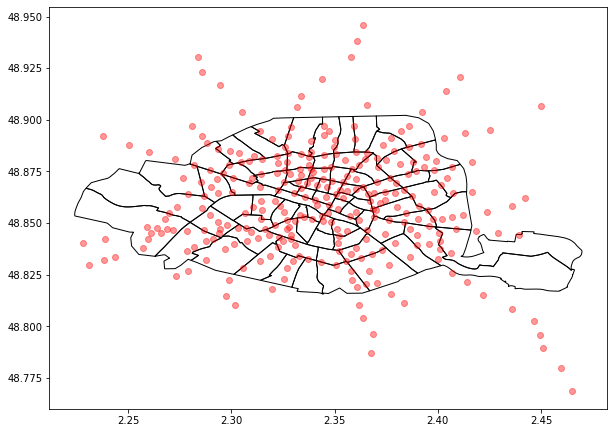

In [61]:
axi = stations_metro.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
quartiers.plot(ax = axi, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)

On associe ensuite à chaque station de métro le quartier auquel elle appartient :

In [55]:
stations_metro_quartiers = gpd.sjoin(stations_metro, quartiers, op='within')

C:\Users\blasc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


In [62]:
stations_metro_quartiers.head(5)

,geometry,index_right,l_qu,c_qu
0,POINT (2.33861 48.88444),34,Clignancourt,70
5,POINT (2.34472 48.88306),34,Clignancourt,70
53,POINT (2.34944 48.88667),34,Clignancourt,70
122,POINT (2.34472 48.89250),34,Clignancourt,70
164,POINT (2.35000 48.89028),34,Clignancourt,70


Il ne reste plus qu'à compter le nombre de stations de métro par quartier, et à l'ajouter aux données.

In [90]:
decompte = stations_metro_quartiers.groupby('c_qu')[['l_qu']].count()
decompte.head(5)

,l_qu
c_qu,
1,2
2,2
3,2
4,1
5,2


In [94]:
donnees_augmentees = donnees.join(decompte, on='id_quartier')
donnees_augmentees.rename(columns={'l_qu': 'metro'}, inplace=True)

In [95]:
donnees_augmentees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,metro
0,Belleville,77,25.0,17.50,30.00,1946-1970,meublé,2,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",1.0
1,Belleville,77,23.6,16.52,28.32,Apres 1990,meublé,3,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ...",1.0
2,Combat,76,19.8,13.86,23.76,1971-1990,meublé,4,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",3.0
3,Amérique,75,21.6,15.12,25.92,1946-1970,meublé,2,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",7.0
4,Saint-Fargeau,78,24.0,16.80,28.80,1971-1990,meublé,1,"POLYGON ((2.41381 48.87081, 2.41383 48.87066, ...",3.0
